# **Google drive mounting**

In [1]:
#Start by connecting gdrive into the google colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **Packages**
In this assignment, we'll make use of the following packages:

*   tensorflow is a framework for building deep learning models.
*   numpy is a library for mathematical and scientific operations.
*   os is a library for manipulating paths, for reading and writing files 
*   opencv is a library for computer vision and image processing
*   matplotlib is a library for interactive visualization 



In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
'''
We define the hyperparameters that will be then used for training: e.g. batch size, lr, number of epochs ect, desired x and y

'''
params = {'x':192, 
          'y':272,
          'batch_size': 8, #
          'n_channels_mask': 1,
          'n_channels': 1,
          'shuffle': True, 
          'length_training': length_training,
          'length_validation':length_validation,
          'learningRate': 0.0001,
          'momentum': 0.98,
          'nEpoches': 20,
          }


dataset = "/content/gdrive/My Drive/Segmentation/" 
modality = ['training','validation']
'''
The format() method formats the specified value(s) and insert them inside the string's placeholder.
listdir: returns a list containing the names of the entries in the directory given by path
'''
length_training = len(os.listdir(os.path.join(dataset,modality[0]+ "/image/{0}".format(modality[0])))) 
length_validation = len(os.listdir(os.path.join(dataset,modality[1] + "/image/{0}".format(modality[1]))))


dim = (params['y'],params['x']) #desired_x, desired_y
Xlist = {}
Ylist = {}
ipp = 0

for i in modality:
  # to fill tensors we inizialise them
    X = np.empty((params['length_{0}'.format(i)], params['x'],params['y'], params['n_channels'])) # dim of X = [number of images, desired_x, desired_y, c]
    y = np.empty((params['length_{0}'.format(i)], params['x'],params['y'], params['n_channels_mask'])) # dim of y = [number of images, x, y, c]
    for im in sorted(os.listdir(os.path.join(dataset,i + "/image/{0}".format(i)))):
        image = cv2.imread(os.path.join(os.path.join(dataset,i+ "/image/{0}".format(i)),im),0)
        image = cv2.resize(image,dim)
        mea = np.mean(image)
        ss = np.std(image)
        image = (image - mea)/ss

        mask = cv2.imread(os.path.join(os.path.join(dataset,i + "/mask/{0}".format(i)),im),0)
        mask = cv2.resize(mask,dim)
        mask = mask / 255


        
        X[ipp,:,:,0] = image
        y[ipp,:,:,0] = mask
        ipp += 1
    Xlist[i] = X
    Ylist[i] = y
    ipp = 0

In [ ]:
X_train = Xlist['training']         
Y_train = Ylist['training']
X_val = Xlist['validation']
Y_val = Ylist['validation']

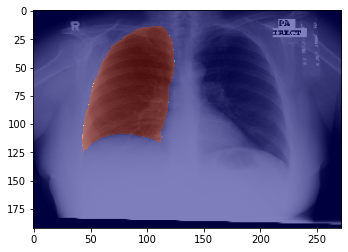

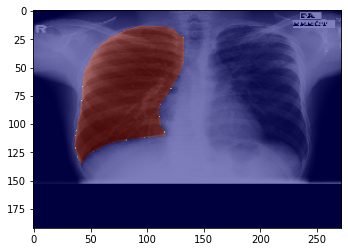

In [ ]:
#visual check

plt.figure(1)
plt.imshow(X_train[10,:,:,0],cmap='gray')
plt.imshow(Y_train[10,:,:,0],'jet', interpolation='none', alpha=0.5)
plt.figure(2)
plt.imshow(X_val[10,:,:,0],cmap='gray')
plt.imshow(Y_val[10,:,:,0],'jet', interpolation='none', alpha=0.5)

**testo in grassetto**# **DataGenerator class**
 In this assignment we will use the DataGenerator class. It is a different way to handle tensors for training and validation.

 DataGenerator class generates itself batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

The augmentation is performed according to the following scheme:

![alt text](https://drive.google.com/uc?id=18F5WVeO14diPDQ6Yu8bOPn4vi4cPgWZB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed = 42
train_datagen = ImageDataGenerator(rotation_range = 25, fill_mode='constant'
                                   )
train_mask_datagen = ImageDataGenerator(rotation_range = 25,fill_mode='constant'
                                        )

vali_datagen = ImageDataGenerator()
vali_mask_datagen = ImageDataGenerator()
train_datagen.fit(X_train, augment=True, seed=seed)
train_mask_datagen.fit(Y_train, augment=True, seed=seed)
train_image_generator = train_datagen.flow(X_train,batch_size = params['batch_size'],shuffle = True,seed=seed)
train_mask_generator = train_mask_datagen.flow(Y_train,batch_size = params['batch_size'],shuffle = True, seed=seed)

train_generator = zip(train_image_generator,train_mask_generator)
vali_datagen.fit(X_val, seed=seed)
vali_mask_datagen.fit(Y_val, seed=seed)
val_image_generator = vali_datagen.flow(X_val,batch_size = params['batch_size'],seed=seed)
val_mask_generator = vali_mask_datagen.flow(Y_val,batch_size = params['batch_size'], seed=seed)
val_generator = zip(val_image_generator,val_mask_generator)

In [ ]:
batchx, batchy = next(train_generator)


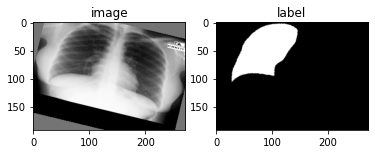

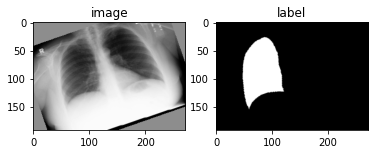

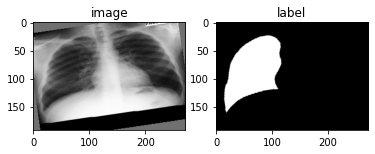

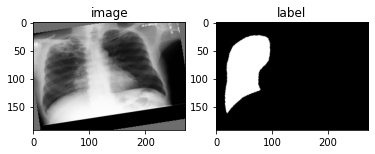

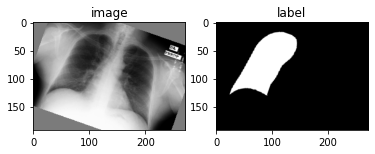

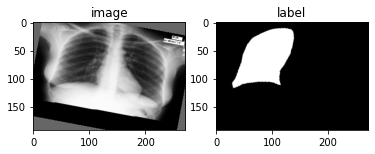

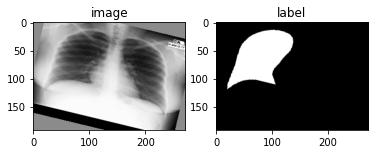

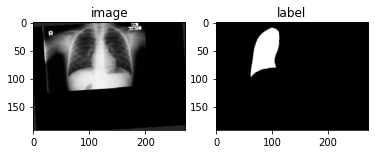

In [ ]:
#examples of random data agumentation
batchx, batchy = next(train_generator)
for i in range(batchx.shape[0]):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    ax1.set_title('image')  
    ax1.imshow(batchx[i][:,:,0], cmap='gray')
    ax2.set_title('label') 
    ax2.imshow(batchy[i][:,:,0], cmap='gray')

# **Semantic-segmentation model training**

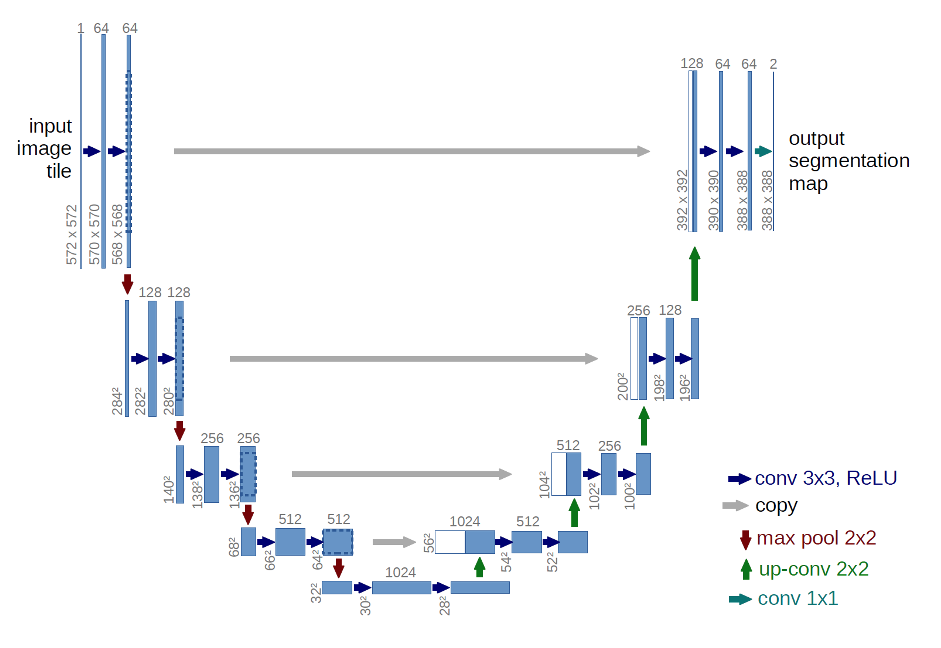








In [ ]:

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,  CSVLogger
#from keras import backend as keras
from tensorflow.keras import backend as k
from tensorflow.keras.initializers import glorot_uniform

initializer = glorot_uniform()

def unet(input_size = (192,272,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#bottleneck
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv5)
#decoding path
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)


    return model

**Training and validation phase --> from scratch**

In [ ]:
model = unet()
model.compile(optimizer = Adam(lr = params["learningRate"]), loss = "binary_crossentropy", metrics = ['accuracy'])
steps_per_epoch = np.ceil(params["length_training"]/ params["batch_size"])

In [ ]:
checkPoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
csv_logger = CSVLogger(root + '/metriche.csv', append=True, separator=';')


history = model.fit_generator(generator=train_generator, steps_per_epoch = steps_per_epoch, epochs = params["nEpoches"],
                    validation_data = val_generator, verbose = 1, validation_steps=params['length_validation']/params["batch_size"],callbacks=[callbacks_list,csv_logger])

Epoch 1/20
14/14 [==============================] - 12s 830ms/step - loss: 0.1157 - accuracy: 0.9804 - val_loss: 0.1199 - val_accuracy: 0.9799
Epoch 2/20
14/14 [==============================] - 12s 845ms/step - loss: 0.1110 - accuracy: 0.9823 - val_loss: 0.1146 - val_accuracy: 0.9852
Epoch 3/20
14/14 [==============================] - 12s 823ms/step - loss: 0.1155 - accuracy: 0.9798 - val_loss: 0.1192 - val_accuracy: 0.9802
Epoch 4/20
14/14 [==============================] - 11s 806ms/step - loss: 0.1106 - accuracy: 0.9824 - val_loss: 0.1094 - val_accuracy: 0.9865
Epoch 5/20
14/14 [==============================] - 11s 800ms/step - loss: 0.1101 - accuracy: 0.9827 - val_loss: 0.1161 - val_accuracy: 0.9829
Epoch 6/20
14/14 [==============================] - 11s 798ms/step - loss: 0.1100 - accuracy: 0.9831 - val_loss: 0.1162 - val_accuracy: 0.9842
Epoch 7/20
14/14 [==============================] - 11s 805ms/step - loss: 0.1101 - accuracy: 0.9831 - val_loss: 0.1153 - val_accuracy: 0.9847

# **Saving weights and training curves**

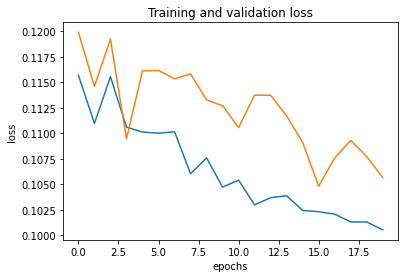

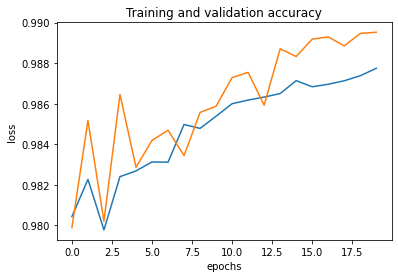

In [ ]:
epochs = params["nEpoches"]


plt.figure()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")


# **Model prediction**

In [ ]:
#load weights
model.load_weights("/content/gdrive/MyDrive/Segmentation/weights_200epochs.h5")

In [ ]:
import cv2
import copy
from tensorflow.keras.preprocessing.image import img_to_array

test_image = cv2.imread(os.path.join(dataset,"MCUCXR_0254_imm.png"),0)
test_mask = cv2.imread(os.path.join(dataset,"MCUCXR_0254.png"),0)

test_image = cv2.resize(test_image,(params["y"],params["x"]))
test_mask = cv2.resize(test_mask,(params["y"],params["x"]))

mean_ = np.mean(test_image)
test_image = test_image - mean_
std = np.std(test_image)
test_image = test_image/std

test_mask = test_mask

test_image = img_to_array(test_image)
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
#model.predict_classes(X_test)
prediction = model.predict(test_image)
pred = copy.copy(prediction)
pred [pred > 0.5] = 1
pred [pred < 0.5] = 0

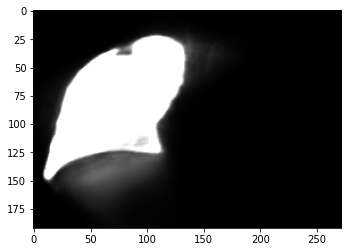

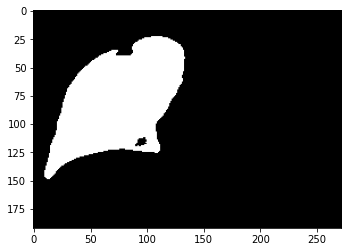

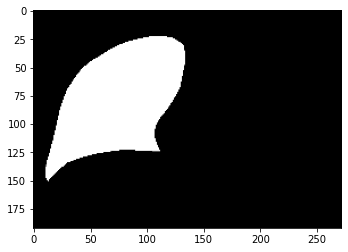

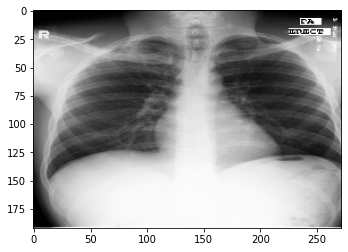

In [ ]:
plt.figure()
plt.imshow(prediction[0,:,:,0], cmap='gray')
plt.figure()
plt.imshow(pred[0,:,:,0], cmap='gray')
plt.figure()
plt.imshow(test_mask, cmap='gray')
plt.figure()
plt.imshow(test_image[0,:,:,0], cmap='gray')

In [ ]:
from sklearn.metrics import accuracy_score
test_mask = test_mask/255
a = test_mask.flatten()
b = pred[0,:,:,0].flatten()
a = a.astype(int)
b = b.astype(int)

accuracy = accuracy_score(a, b)
print("testing accuracy", accuracy)

testing accuracy 0.9907705269607843


<a name="3-1"></a>
## 3.1 Dice Similarity Coefficient

Aside from the architecture, one of the most important elements of any deep learning method is the choice of our **loss function**. 

A natural choice that you may be familiar with is the cross-entropy loss function. 
- However, this loss function is not ideal for segmentation tasks due to heavy **class imbalance** (there are typically not many positive regions). 

A much more common loss for segmentation tasks is the **Dice similarity coefficient**, which is a measure of how well two contours overlap. 
- The Dice index ranges from 0 (complete mismatch) 
- To 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$


<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">

[Image Source](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)

Implement the dice coefficient for a single output class below.

- Please use the [Keras.sum(x,axis=)](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sum) function to compute the numerator and denominator of the dice coefficient.

In [ ]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [ ]:
dice(test_mask, pred[0,:,:,0])

0.9724422626352783